## Diabetic Retinopathy

**Diabetic retinopathy** is a diabetes complication that affects eyes. It's caused by damage to the blood vessels of the light-sensitive tissue at the back of the eye (retina). At first, diabetic retinopathy may cause no symptoms or only mild vision problems.

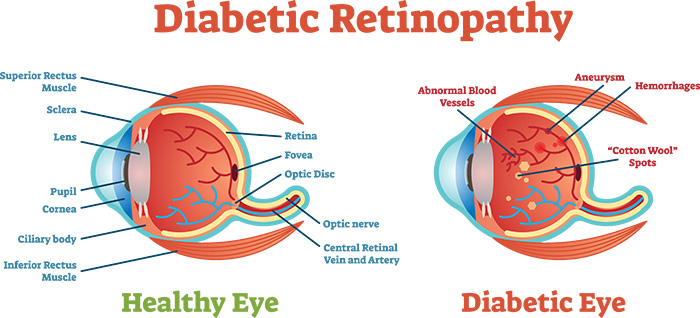

You might not have symptoms in the early stages of diabetic retinopathy. As the condition progresses, diabetic retinopathy symptoms may include:

* Spots or dark strings floating in your vision (floaters)
* Blurred vision
* Fluctuating vision
* Impaired color vision
* Dark or empty areas in your vision
* Vision loss
* Diabetic retinopathy usually affects both eyes.

**Diabetic retinopathy can lead to other serious eye conditions:** 

1. Diabetic macular edema (DME). Over time, about half of people with diabetic retinopathy will develop DME. DME happens when blood vessels in the retina leak fluid, causing swelling in the macula (a part of the retina). If you have DME, your vision will become blurry because of the extra fluid in your macula.  

2. Neovascular glaucoma. Diabetic retinopathy can cause abnormal blood vessels to grow out of the retina and block fluid from draining out of the eye. This causes a type of glaucoma.

Diabetic retinopathy is caused by high blood sugar due to diabetes. Over time, having too much sugar in your blood can damage your retina — the part of your eye that detects light and sends signals to your brain through a nerve in the back of your eye (optic nerve).  



Diabetes damages blood vessels all over the body. The damage to your eyes starts when sugar blocks the tiny blood vessels that go to your retina, causing them to leak fluid or bleed. To make up for these blocked blood vessels, your eyes then grow new blood vessels that don’t work well. These new blood vessels can leak or bleed easily. 

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Upgrade pip
!/opt/conda/bin/python3.7 -m pip install --upgrade pip

# Install efficientnet package
!pip install -q efficientnet
import efficientnet.tfkeras as efn

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
input_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
output_dir = '/kaggle/working'

# Check dataset size and collect file paths
file_paths = []
labels = []
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

total_images = 0
for class_dir in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_dir)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith('.png') or f.endswith('.jpg')])
        print(f"{class_dir}: {num_images} images")
        total_images += num_images
        for img_file in os.listdir(class_path):
            if img_file.endswith('.png') or img_file.endswith('.jpg'):
                file_paths.append(os.path.join(class_path, img_file))
                labels.append(class_to_idx[class_dir])
print(f"Total images: {total_images}")

# Create DataFrame for file paths and labels
df = pd.DataFrame({'filename': file_paths, 'label': labels})

# Convert labels to strings for flow_from_dataframe
df['label'] = df['label'].astype(str)

# Split dataset: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Data preparation with ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_data = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Custom learning rate scheduler
def lr_rate(epoch, lr):
    if epoch < 10:
        lr = 0.0001
        return lr
    elif epoch <= 15:
        lr = 0.0005
        return lr
    elif epoch <= 30:
        lr = 0.0001
        return lr
    else:
        lr = lr * (epoch / (1 + epoch))
        return lr

# Callbacks
callbacks = [
    LearningRateScheduler(lr_rate),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
]

# Function to build CNN model
def build_cnn_model(base_model, name):
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    return model, name

# Initialize models
efficientnet = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

models = [
    build_cnn_model(efficientnet, 'EfficientNetB0'),
    build_cnn_model(vgg16, 'VGG16')
]


def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 5), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(f'Model {title}')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'])
    plt.show()





Mild: 370 images
Proliferate_DR: 295 images
Moderate: 999 images
No_DR: 1805 images
Severe: 193 images
Total images: 3662
Training set: 2929 images
Validation set: 366 images
Test set: 367 images
Found 2929 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


In [10]:
# Train EfficientNetB0
efficientnet = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_efficientnet, name_efficientnet = build_cnn_model(efficientnet, 'EfficientNetB0')

history_efficientnet = model_efficientnet.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
92/92 [==============================] - 41s 447ms/step - loss: 5.5805 - accuracy: 0.6429 - auc: 0.8679 - val_loss: 4.5983 - val_accuracy: 0.7240 - val_auc: 0.9272 - lr: 1.0000e-04
Epoch 2/30
92/92 [==============================] - 40s 431ms/step - loss: 4.1019 - accuracy: 0.6989 - auc: 0.9070 - val_loss: 3.4537 - val_accuracy: 0.7459 - val_auc: 0.9351 - lr: 1.0000e-04
Epoch 3/30
92/92 [==============================] - 40s 434ms/step - loss: 3.2278 - accuracy: 0.7037 - auc: 0.9096 - val_loss: 2.7686 - val_accuracy: 0.7377 - val_auc: 0.9370 - lr: 1.0000e-04
Epoch 4/30
92/92 [==============================] - 40s 435ms/step - loss: 2.6516 - accuracy: 0.7050 - auc: 0.9129 - val_loss: 2.3405 - val_accuracy: 0.7268 - val_auc: 0.9352 - lr: 1.0000e-04
Epoch 5/30
92/92 [==============================] - 39s 428ms/step - loss: 2.2543 - accuracy: 0.7040 - auc: 0.9151 - val_loss: 1.9778 - val_accuracy: 0.7377 - val_auc: 0.9410 - lr: 1.0000e-04
Epoch 6/30
92/92 [======================

In [9]:
# Train VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg16, name_vgg16 = build_cnn_model(vgg16, 'VGG16')

history_vgg16 = model_vgg16.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
92/92 [==============================] - 41s 445ms/step - loss: 4.1978 - accuracy: 0.6330 - auc: 0.8629 - val_loss: 2.8011 - val_accuracy: 0.6995 - val_auc: 0.9054 - lr: 1.0000e-04
Epoch 2/30
92/92 [==============================] - 41s 448ms/step - loss: 2.3895 - accuracy: 0.6736 - auc: 0.8893 - val_loss: 2.0090 - val_accuracy: 0.6858 - val_auc: 0.9069 - lr: 1.0000e-04
Epoch 3/30
92/92 [==============================] - 40s 439ms/step - loss: 1.8624 - accuracy: 0.6927 - auc: 0.8983 - val_loss: 1.6701 - val_accuracy: 0.6940 - val_auc: 0.9149 - lr: 1.0000e-04
Epoch 4/30
92/92 [==============================] - 41s 446ms/step - loss: 1.6210 - accuracy: 0.6917 - auc: 0.9000 - val_loss: 1.4700 - val_accuracy: 0.6967 - val_auc: 0.9199 - lr: 1.0000e-04
Epoch 5/30
92/92 [==============================] - 41s 448ms/step - loss: 1.4722 - accuracy: 0.6893 - auc: 0.9009 - val_loss: 1.3824 - val_accuracy: 0.6995 - val_auc: 0.9120 - lr: 1.0000e-04
Epoch 6/30
92/92 [======================

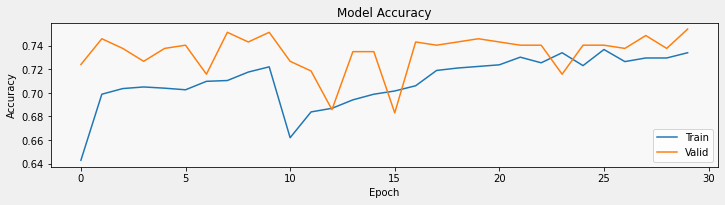

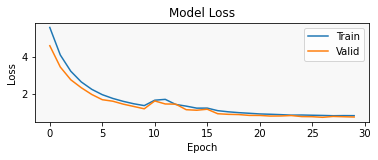

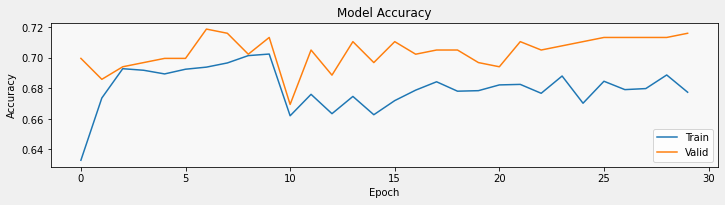

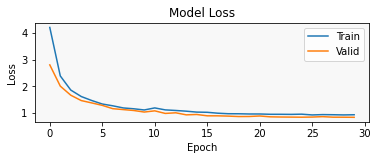

In [13]:
# EfficientNetB0
display_training_curves(history_efficientnet.history['accuracy'], history_efficientnet.history['val_accuracy'], 'Accuracy', 211)
display_training_curves(history_efficientnet.history['loss'], history_efficientnet.history['val_loss'], 'Loss', 212)

# Plotting VGG16 training curves
display_training_curves(history_vgg16.history['accuracy'], history_vgg16.history['val_accuracy'], 'Accuracy', 211)
display_training_curves(history_vgg16.history['loss'], history_vgg16.history['val_loss'], 'Loss', 212)


In [14]:
# Evaluate EfficientNet
test_loss_eff, test_acc_eff, test_auc_eff = model_efficientnet.evaluate(test_data)
print(f"EfficientNetB0 - Test Accuracy: {test_acc_eff:.4f}, AUC: {test_auc_eff:.4f}")

# Evaluate VGG16
test_loss_vgg, test_acc_vgg, test_auc_vgg = model_vgg16.evaluate(test_data)
print(f"VGG16 - Test Accuracy: {test_acc_vgg:.4f}, AUC: {test_auc_vgg:.4f}")


12/12 [==============================] - 1s 95ms/step - loss: 0.8014 - accuracy: 0.7384 - auc: 0.9387
EfficientNetB0 - Test Accuracy: 0.7384, AUC: 0.9387
12/12 [==============================] - 3s 275ms/step - loss: 0.9004 - accuracy: 0.6948 - auc: 0.9109
VGG16 - Test Accuracy: 0.6948, AUC: 0.9109


EfficientNetB0 Classification Report:
                precision    recall  f1-score   support

         No_DR       0.91      0.96      0.94       181
          Mild       0.57      0.11      0.18        37
      Moderate       0.55      0.93      0.69       100
        Severe       0.00      0.00      0.00        19
Proliferate_DR       0.00      0.00      0.00        30

      accuracy                           0.74       367
     macro avg       0.41      0.40      0.36       367
  weighted avg       0.66      0.74      0.67       367



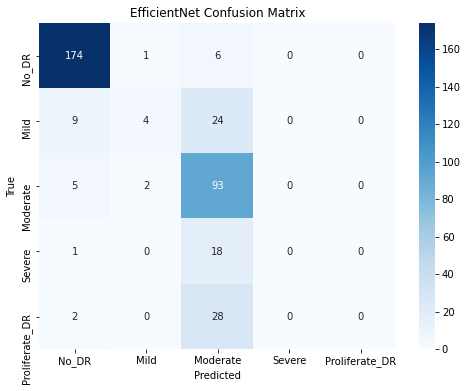

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using EfficientNet
y_true = test_data.classes
y_pred_probs = model_efficientnet.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("EfficientNetB0 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNet Confusion Matrix')
plt.show()


VGG16 Classification Report:
                precision    recall  f1-score   support

         No_DR       0.85      0.95      0.90       181
          Mild       0.00      0.00      0.00        37
      Moderate       0.50      0.83      0.63       100
        Severe       0.00      0.00      0.00        19
Proliferate_DR       0.00      0.00      0.00        30

      accuracy                           0.69       367
     macro avg       0.27      0.36      0.30       367
  weighted avg       0.56      0.69      0.61       367



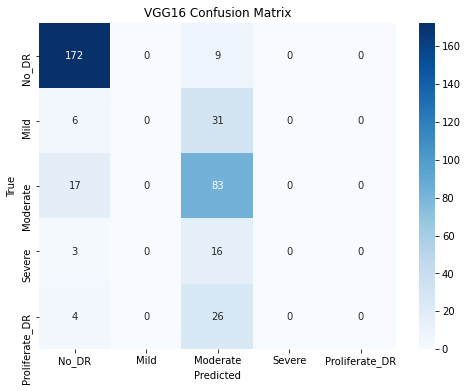

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using VGG16
y_true_vgg = test_data.classes
y_pred_probs_vgg = model_vgg16.predict(test_data)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)

# Classification report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true_vgg, y_pred_vgg, target_names=class_names))

# Confusion matrix for VGG16
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('VGG16 Confusion Matrix')
plt.show()


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# EfficientNet
!pip install -q efficientnet
import efficientnet.tfkeras as efn

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
input_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

# Class names and label mapping
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Load image paths and labels
file_paths, labels = [], []
for class_dir in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            if img_file.endswith(('.png', '.jpg')):
                file_paths.append(os.path.join(class_path, img_file))
                labels.append(class_to_idx[class_dir])

# Build dataframe
df = pd.DataFrame({'filename': file_paths, 'label': labels})
df['label'] = df['label'].astype(str)

# Train/validation/test split
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# ⚠️ Oversample only for training generator — NOT for computing class weights
severe_df = train_df[train_df['label'] == '3']
proliferate_df = train_df[train_df['label'] == '4']
train_df_oversampled = pd.concat([train_df] + [severe_df]*4 + [proliferate_df]*2, ignore_index=True)

# ✅ Compute class weights from original (imbalanced) train_df
y_int_labels = train_df['label'].astype(int)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_int_labels), y=y_int_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_dataframe(
    train_df_oversampled, x_col='filename', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
)
val_data = val_test_datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)
test_data = val_test_datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

# Learning rate scheduler and callbacks
callbacks = [
    LearningRateScheduler(
        lambda epoch, lr: 0.0001 if epoch < 10 else (0.0005 if epoch <= 15 else (0.0001 if epoch <= 30 else lr * (epoch / (1 + epoch)))),
        verbose=0
    ),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5),
    ModelCheckpoint(
        filepath=os.path.join('/kaggle/working', 'checkpoint_{epoch:02d}.h5'),
        save_best_only=False,
        save_freq='epoch'
    )
]

# Model builder function
def build_or_load_model(base_model, name):
    model_path = os.path.join('/kaggle/working', f'{name}_model.h5')
    if os.path.exists(model_path):
        print(f"Loading pre-trained {name} model...")
        return load_model(model_path)
    else:
        print(f"Building new {name} model...")
        for layer in base_model.layers[:-10]:
            layer.trainable = False
        for layer in base_model.layers[-10:]:
            layer.trainable = True
        x = Flatten()(base_model.output)
        x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.5)(x)
        output = Dense(5, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
        return model


Class Weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}
Found 4017 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


In [33]:
# Train EfficientNetB0
efficientnet = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_eff = build_or_load_model(efficientnet, 'EfficientNetB0')
history_eff = model_eff.fit(train_data, validation_data=val_data, epochs=40,
                            class_weight=class_weights_dict, callbacks=callbacks, verbose=1)


Building new EfficientNetB0 model...
Epoch 1/40
126/126 [==============================] - 59s 471ms/step - loss: 7.3669 - accuracy: 0.4650 - auc: 0.7632 - val_loss: 6.1911 - val_accuracy: 0.4918 - val_auc: 0.7623 - lr: 1.0000e-04
Epoch 2/40
126/126 [==============================] - 56s 447ms/step - loss: 6.3805 - accuracy: 0.5116 - auc: 0.8158 - val_loss: 5.4106 - val_accuracy: 0.5464 - val_auc: 0.8547 - lr: 1.0000e-04
Epoch 3/40
126/126 [==============================] - 56s 444ms/step - loss: 5.8455 - accuracy: 0.5395 - auc: 0.8380 - val_loss: 5.1364 - val_accuracy: 0.5464 - val_auc: 0.8399 - lr: 1.0000e-04
Epoch 4/40
126/126 [==============================] - 56s 442ms/step - loss: 5.3205 - accuracy: 0.5619 - auc: 0.8488 - val_loss: 4.5363 - val_accuracy: 0.5710 - val_auc: 0.8583 - lr: 1.0000e-04
Epoch 5/40
126/126 [==============================] - 56s 442ms/step - loss: 4.8786 - accuracy: 0.5691 - auc: 0.8584 - val_loss: 4.2213 - val_accuracy: 0.5765 - val_auc: 0.8654 - lr: 1.00

In [44]:
# Train VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_vgg = build_or_load_model(vgg16, 'VGG16')
history_vgg = model_vgg.fit(train_data, validation_data=val_data, epochs=40,
                            class_weight=class_weights_dict, callbacks=callbacks, verbose=1)


Building new VGG16 model...
Epoch 1/40
126/126 [==============================] - 59s 471ms/step - loss: 4.5011 - accuracy: 0.3692 - auc: 0.6783 - val_loss: 2.7649 - val_accuracy: 0.3579 - val_auc: 0.5503 - lr: 1.0000e-04
Epoch 2/40
126/126 [==============================] - 58s 460ms/step - loss: 2.5505 - accuracy: 0.4812 - auc: 0.7863 - val_loss: 1.5808 - val_accuracy: 0.5410 - val_auc: 0.8510 - lr: 1.0000e-04
Epoch 3/40
126/126 [==============================] - 57s 454ms/step - loss: 2.2346 - accuracy: 0.5076 - auc: 0.7974 - val_loss: 1.5816 - val_accuracy: 0.5191 - val_auc: 0.8281 - lr: 1.0000e-04
Epoch 4/40
126/126 [==============================] - 58s 461ms/step - loss: 2.0511 - accuracy: 0.5357 - auc: 0.8187 - val_loss: 1.6629 - val_accuracy: 0.4754 - val_auc: 0.7706 - lr: 1.0000e-04
Epoch 5/40
126/126 [==============================] - 58s 460ms/step - loss: 1.9547 - accuracy: 0.5464 - auc: 0.8344 - val_loss: 1.2138 - val_accuracy: 0.5874 - val_auc: 0.8735 - lr: 1.0000e-04
Ep

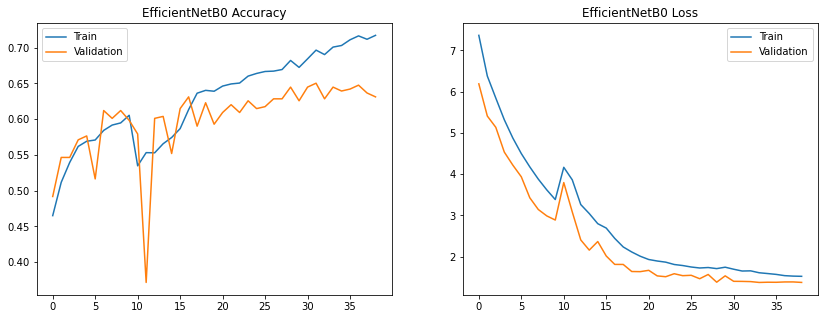

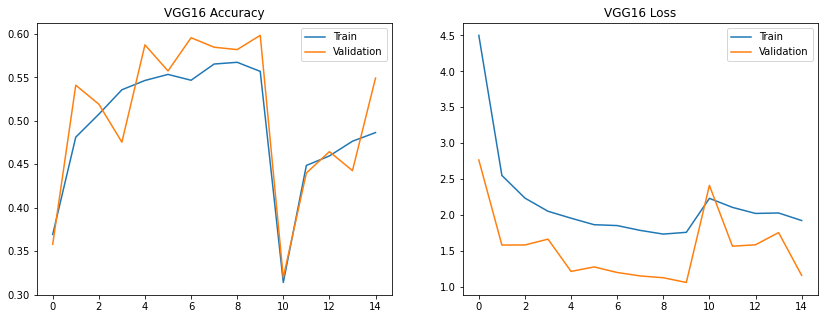

In [45]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    axs[0].plot(history.history['accuracy'], label='Train')
    axs[0].plot(history.history['val_accuracy'], label='Validation')
    axs[0].set_title(f'{model_name} Accuracy')
    axs[0].legend()

    axs[1].plot(history.history['loss'], label='Train')
    axs[1].plot(history.history['val_loss'], label='Validation')
    axs[1].set_title(f'{model_name} Loss')
    axs[1].legend()

    plt.show()

plot_history(history_eff, 'EfficientNetB0')

plot_history(history_vgg, 'VGG16')


EfficientNetB0 Evaluation:
12/12 [==============================] - 2s 129ms/step - loss: 1.4051 - accuracy: 0.6458 - auc: 0.9207
Accuracy: 0.6458, AUC: 0.9207
                precision    recall  f1-score   support

         No_DR       0.96      0.93      0.94       181
          Mild       0.44      0.73      0.55        37
      Moderate       0.68      0.15      0.25       100
        Severe       0.20      0.58      0.30        19
Proliferate_DR       0.30      0.53      0.39        30

      accuracy                           0.65       367
     macro avg       0.52      0.58      0.48       367
  weighted avg       0.74      0.65      0.63       367



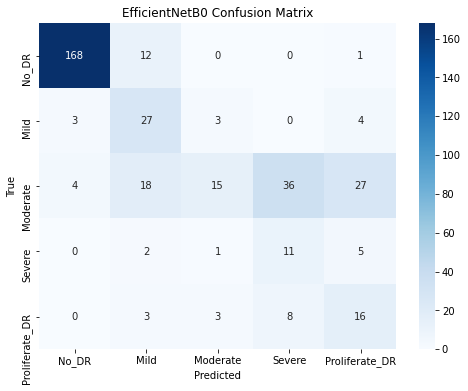


VGG16 Evaluation:
12/12 [==============================] - 2s 140ms/step - loss: 1.0695 - accuracy: 0.5831 - auc: 0.8819
Accuracy: 0.5831, AUC: 0.8819
                precision    recall  f1-score   support

         No_DR       0.93      0.94      0.94       181
          Mild       0.41      0.57      0.48        37
      Moderate       0.00      0.00      0.00       100
        Severe       0.14      0.79      0.24        19
Proliferate_DR       0.26      0.23      0.25        30

      accuracy                           0.58       367
     macro avg       0.35      0.51      0.38       367
  weighted avg       0.53      0.58      0.54       367



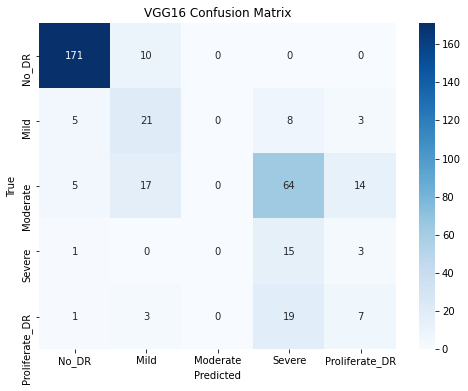

In [46]:
def evaluate_model(model, test_data, model_name):
    print(f"\n{model_name} Evaluation:")
    loss, acc, auc_val = model.evaluate(test_data)
    print(f"Accuracy: {acc:.4f}, AUC: {auc_val:.4f}")

    y_true_list = []
    for i in range(len(test_data)):
        _, labels = test_data[i]
        y_true_list.append(labels)
    y_true = np.argmax(np.concatenate(y_true_list, axis=0), axis=1)
    
    y_pred_probs = model.predict(test_data)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  # Add this line to display the confusion matrix


# Run evaluations
evaluate_model(model_eff, test_data, 'EfficientNetB0')
evaluate_model(model_vgg, test_data, 'VGG16')


In [42]:
# Save final models
model_eff.save('/kaggle/working/EfficientNetB0_model.h5')
